In [1]:
import pandas as pd  
import numpy as np 
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import MinMaxScaler  
from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt 
import seaborn as sns 
from keras.layers import Input, Dense 
from keras.models import Model, Sequential 
from keras import regularizers

Using TensorFlow backend.


In [2]:
homedata = pd.read_csv(r'C:\Users\lazrag\Desktop\Training Dataset\Home\CSVs\allhome.csv', low_memory=False)
homedata["Label"]="home"

targethomedata= pd.read_csv(r'C:\Users\lazrag\Desktop\Training Dataset\TargetHome\CSVs\targethome.csv', low_memory=False)
targethomedata["Label"]="home"

nothomedata = pd.read_csv(r'C:\Users\lazrag\Desktop\Training Dataset\NotHome\CSVs\allnothome.csv', low_memory=False)
nothomedata["Label"]="nothome"

homedata = homedata[homedata['Protocol'] == 6]
nothomedata = nothomedata[nothomedata['Protocol'] == 6]
targethomedata = targethomedata[targethomedata['Protocol'] == 6]
nothomedata=nothomedata.head(n=500)

print(homedata.shape)
print(nothomedata.shape)
print(targethomedata.shape)

(4101, 84)
(500, 84)
(38608, 84)


In [3]:
data=homedata.append(nothomedata)
print(data.shape)

(4601, 84)


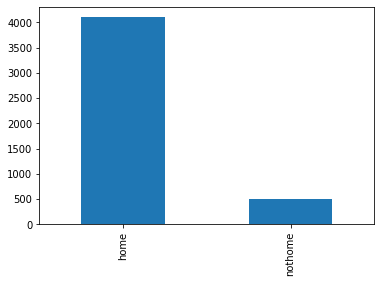

In [4]:
data.Label.value_counts().plot(kind='bar')

In [5]:
data["Flow Duration"] = np.log((data["Flow Duration"] + 0.1).astype(float)) 

if len(data) !=  0:
    data.loc[data['Label'] == "home","nothome"] = 1 
    data.loc[data['Label'] != "home","nothome"] = -1

target = data['nothome']

outliers = target[target == -1]
print("outliers.shape", outliers.shape)
print("outlier fraction", outliers.shape[0]/target.shape[0])
print(target)

data.drop(["Label", "nothome"], axis=1, inplace=True)
data.drop(['Flow ID','Dst IP','Src Port', 'Dst Port','Src IP','Timestamp'], axis=1, inplace=True)
data.shape

outliers.shape (500,)
outlier fraction 0.10867202782003912
0      1.0
1      1.0
4      1.0
5      1.0
8      1.0
      ... 
603   -1.0
604   -1.0
605   -1.0
606   -1.0
608   -1.0
Name: nothome, Length: 4601, dtype: float64


(4601, 77)

In [6]:
targethomedata["Flow Duration"] = np.log((targethomedata["Flow Duration"] + 0.1).astype(float)) 

if len(targethomedata) !=  0:
    targethomedata.loc[targethomedata['Label'] == "home","nothome"] = 1 
    targethomedata.loc[targethomedata['Label'] != "home","nothome"] = -1

targethome = targethomedata['nothome']
print(targethome)

targethomedata.drop(["Label", "nothome"], axis=1, inplace=True)
targethomedata.drop(['Flow ID','Dst IP','Src Port', 'Dst Port','Src IP','Timestamp'], axis=1, inplace=True)
targethomedata.shape

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
118503    1.0
118505    1.0
118507    1.0
118510    1.0
118511    1.0
Name: nothome, Length: 38608, dtype: float64


C:\Users\lazrag\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(38608, 77)

In [7]:
from sklearn.preprocessing import minmax_scale


In [8]:
train_scaled = minmax_scale(data, axis = 0)
test_scaled = minmax_scale(targethomedata, axis = 0)

In [9]:
nbrcol = train_scaled.shape[1]


In [10]:
#Split some training and test data from the source set to evaluate later
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(train_scaled, train_size = 0.6)

In [11]:
# Building the Input Layer 
input_layer = Input(shape =(nbrcol, )) 
  
# Building the Encoder network 
encoded = Dense(100, activation ='tanh', 
                activity_regularizer = regularizers.l1(10e-5))(input_layer) 
encoded = Dense(50, activation ='tanh', 
                activity_regularizer = regularizers.l1(10e-5))(encoded) 
encoded = Dense(25, activation ='tanh', 
                activity_regularizer = regularizers.l1(10e-5))(encoded) 
encoded = Dense(12, activation ='tanh', 
                activity_regularizer = regularizers.l1(10e-5))(encoded) 
encoded = Dense(6, activation ='relu')(encoded) 
  
# Building the Decoder network 
decoded = Dense(12, activation ='tanh')(encoded) 
decoded = Dense(25, activation ='tanh')(decoded) 
decoded = Dense(50, activation ='tanh')(decoded) 
decoded = Dense(100, activation ='tanh')(decoded) 
  
# Building the Output Layer 
output_layer = Dense(nbrcol, activation ='relu')(decoded) 

In [12]:
autoencoder = Model(input_layer, output_layer) 
autoencoder.compile(optimizer ="adadelta", loss ="mse") 

In [13]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 77)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               7800      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_4 (Dense)              (None, 12)                312       
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_6 (Dense)              (None, 12)                84  

In [14]:
train = autoencoder.fit(train_data, train_data, nb_epoch = 10, batch_size = 32, shuffle = False, validation_data = (test_data, test_data))

C:\Users\lazrag\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.



Train on 2760 samples, validate on 1841 samples
Epoch 1/10
2760/2760 [==============================] - 1s 210us/step - loss: 0.1014 - val_loss: 0.0694
Epoch 2/10
2760/2760 [==============================] - 0s 78us/step - loss: 0.0659 - val_loss: 0.0598
Epoch 3/10
2760/2760 [==============================] - 0s 77us/step - loss: 0.0599 - val_loss: 0.0553
Epoch 4/10
2760/2760 [==============================] - 0s 77us/step - loss: 0.0557 - val_loss: 0.0511
Epoch 5/10
2760/2760 [==============================] - 0s 76us/step - loss: 0.0518 - val_loss: 0.0444
Epoch 6/10
2760/2760 [==============================] - 0s 77us/step - loss: 0.0460 - val_loss: 0.0426
Epoch 7/10
2760/2760 [==============================] - 0s 77us/step - loss: 0.0443 - val_loss: 0.0430
Epoch 8/10
2760/2760 [==============================] - 0s 76us/step - loss: 0.0428 - val_loss: 0.0434
Epoch 9/10
2760/2760 [==============================] - 0s 77us/step - loss: 0.0418 - val_loss: 0.0414
Epoch 10/10
2760/2760 [

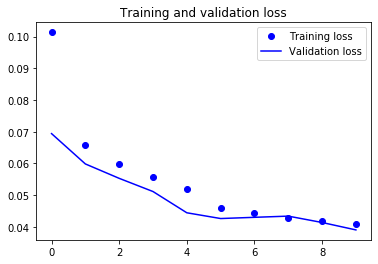

In [15]:
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()